# Politician Face Recognition

## Step by Step strategy for face recognition:

### 1. Data Collection
To start face recognition or any DL problems first we need data. Here as we are predicting the faces of politicians I created the directory with name `data`, with two sub directories `train` and `valid`. In each sub-directory I created folder for 4 politcians: **Narenda Modi, Mamta Banerjee, Rahul Gandhi and Arvind Kejriwal**. And around 14 images(each images were downloaded from internet sources) were assimilated in each training subdirectory for each politicians. And 5 images were assimililated in each valid sub-directory for each politicians.


### 2. Face Detection 
Next, we need to detect face from all the images and cut out that much part from the image. This is very important step as for face recognition every pixels other than faces in th image will be junk for the model. Face detection is one of the challenging problems in deep learning. We are using here `MTCNN` model which has already been trained to detect faces from an image.

### 3. Embedding face
Next most important step in face recognition is associating a vector to each faces so show the closeness of each images. I used **facenet** **https://arxiv.org/abs/1503.03832** model to associate the vector with each faces. This vector is `128 dimensional`, and 128 features are associated to each image. Closeness of vectors in embedded space shows the similarity of each images. Deep CNN models have been trained to optimize embedding. We are using pretrained facenet model. Model is taken from "https://github.com/nyoki-mtl/keras-facenet". 

### 4. Classification of Images
Once embedded vectors are associated, the final task to create classification model for images. I created deep neural network model for classification. The results of the model is very robust.

## Importing Necessary Libraries

In [1]:
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray
from mtcnn.mtcnn import MTCNN

from numpy import load
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
from keras.models import load_model

from numpy import load
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

Using TensorFlow backend.


## Detecting Faces

In [13]:
# Creating an MTCNN face dectector class 
face_detect = MTCNN()

In [14]:
train_dir = 'data/train/'
test_dir = 'data/valid/'

In [17]:
#Segemented images for training data 
#will be stored in 'train_img' list
train_img = []

#Labels for each images will be stored
#in train_label list
train_label = []

for subdir in listdir(train_dir):
    directory = train_dir + subdir + '/'
    for file in listdir(directory):
        file_path = directory+file
        
        image = Image.open(file_path)
        image = image.convert('RGB')
        image_array = asarray(image)
        detected_face = face_detect.detect_faces(image_array)
        
        x_min, y_min, width, heigth = detected_face[0]['box']
        x_max = x_min + width
        y_max = y_min + heigth
        
        just_face_array = image_array[y_min:y_max, x_min:x_max]
        image = Image.fromarray(just_face_array)
        image = image.resize((160,160))
        just_face_array = asarray(image)
        
        train_img.append(just_face_array)
        train_label.append(subdir)
        

test_img = []
test_label = []

for subdir in listdir(test_dir):
    directory = test_dir + subdir + '/'
    for file in listdir(directory):
        file_path = directory+file

        image = Image.open(file_path)
        image = image.convert('RGB')
        image_array = asarray(image)
        detected_face = face_detect.detect_faces(image_array)
        
        x_min, y_min, width, heigth = detected_face[0]['box']
        x_max = x_min + width
        y_max = y_min + heigth
        
        just_face_array = image_array[y_min:y_max, x_min:x_max]
        image = Image.fromarray(just_face_array)
        image = image.resize((160,160))
        just_face_array = asarray(image)
        
        test_img.append(just_face_array)
        test_label.append(subdir)

Check whether images have been detected of properly or not from the images

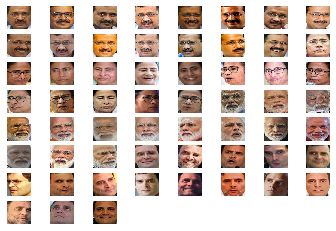

Total number of faces for training: 59


In [198]:
for i,j in enumerate(train_img):
    pyplot.subplot(8, 8, i+1)
    pyplot.axis('off')
    pyplot.imshow(j)
plt.show()
print('Total number of faces for training:',59)

## Associating Embedding Vector to Faces

In [26]:
facenet_model = load_model('facenet_keras.h5')

C:\Users\HP\Anaconda3\envs\intuitive-deep-learning\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


We need to preprocess the image in appropriate way, to make it compatible to feed it to facenet model, and then we will predict embedding vectors for each images

In [35]:
train_embedding = []

for face in train_img:
    #Preprocessing the image for facenet model
    face = face.astype('float32')
    mean, std = face.mean(), face.std()
    face = (face-mean)/std
    expanded_dim_face = expand_dims(face, axis=0)
    
    #Predicting embeddings for training images
    face_embeddings = facenet_model.predict(expanded_dim_face)[0]
    
    train_embedding.append(face_embeddings)
    
test_embedding = []

for face in test_img:
    face = face.astype('float32')
    mean, std = face.mean(), face.std()
    face = (face-mean)/std
    expanded_dim_face = expand_dims(face, axis=0)
    
    #Predicting embeddings for testing images
    face_embeddings = facenet_model.predict(expanded_dim_face)[0]
    
    test_embedding.append(face_embeddings)

In [36]:
np.shape(test_embedding)

(20, 128)

Normalizing embedding vectors to perform well

In [39]:
#Normalizing embedding vectors to perform well
normalizer = Normalizer(norm = 'l2')
train_class = normalizer.transform(train_embedding)
test_class = normalizer.transform(test_embedding)

In [41]:
# Here we are converting the labels into numerical form
# which are actually in string form
label_converter = LabelEncoder()
label_converter.fit(train_label)
train_label = label_converter.transform(train_label)
test_label = label_converter.transform(test_label)

## Creating Classification Model using Neural Network

In [48]:
import tensorflow as tf
from tensorflow.keras.layers import Dense

In [183]:
# Creating Neural Network model for classification of images
inputs = tf.keras.Input(shape=(128,))
x = tf.keras.layers.Dense(64, activation='selu')(inputs)
x = tf.keras.layers.Dense(28, activation='selu')(inputs)
outputs = tf.keras.layers.Dense(4, activation=tf.nn.softmax)(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [184]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

In [185]:
history = model.fit(train_class, train_label, epochs = 70, verbose = 0)

In [193]:
print ('After training for 70 epochs, model achieved Accuracy: (%.3f) and Loss: (%.3f)'%(history.history['accuracy'][-1], history.history['loss'][-1]))

After training for 70 epochs, model achieved Accuracy: (1.000) and Loss: (0.059)


Text(0, 0.5, 'Loss')

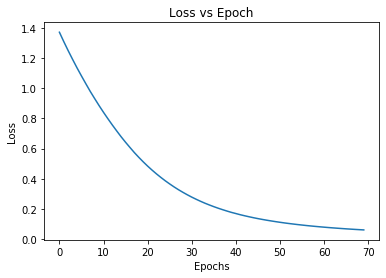

In [190]:
plt.plot(history.history['loss'])
plt.title('Loss vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')

### In next cell we are checking the performance of our code and visualizing its results. by checking its random predictions

Predicted Politician is: rahul **** predicted with probability: (97.247)
Actual Politician is: rahul


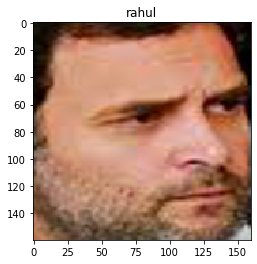

In [171]:
import numpy as np
from random import choice

random_select = choice(np.arange(0,len(test_class)))
rand_img = test_img[random_select]
rand_emb = test_class[random_select]
rand_test_label = test_label[random_select]

actual_name = label_converter.inverse_transform([rand_test_label])

rand_class_pred = model.predict(expand_dims(rand_emb,axis=0))
name_predicted = label_converter.inverse_transform([np.argmax(
                rand_class_pred)])


title = name_predicted[0]

plt.imshow(rand_img)
plt.title(title)

print ('Predicted Politician is: %s **** predicted with probability: (%.3f)'
       % (name_predicted[0], np.max(rand_class_pred)*100))
print ('Actual Politician is: %s'% (actual_name[0]))